In [15]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import datetime
plt.ion()   # interactive mode

PATH = os.getcwd() + "/checkpoint/latestmodelv2.pt"

In [16]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=data_transforms['train'])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=data_transforms['val'])
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

dataloaders = {'train': trainloader , 'val': testloader }

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset_sizes = {'train': len(trainset) , 'val': len(testset) }

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


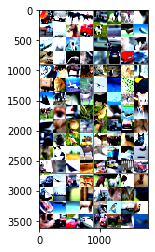

truck   car horse horse


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    #best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    val_loss= 100
    val_acc = -1
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step(val_loss)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'val':
                val_loss = epoch_loss
                val_acc = epoch_acc

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            print( "Epoch Finish Time: ", datetime.datetime.now() )

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                #best_model_wts = copy.deepcopy(model.state_dict())
                
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': val_loss,
                'val_acc' : val_acc,
                
            }, PATH)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
#Model Def
m = models.resnet50()
m.fc = nn.Linear(2048, len(classes))

m = m.to(device)


criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(m.parameters(), lr=0.1, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=90, gamma=0.1)
#exp_lr_scheduler = ReduceLROnPlateau( optimizer_conv,patience=5,min_lr=0.5e-6)

In [7]:
print(PATH)

/home/jupyter/HW5/checkpoint/latestmodelv2.pt


In [ ]:
print("Training Start Time: ", datetime.datetime.now() )
m = train_model(m, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=350)

Training Start Time:  2019-12-11 16:54:48.482503
Epoch 0/349
----------
train Loss: 2.0333 Acc: 0.2172
Epoch Finish Time:  2019-12-11 16:57:17.065620
val Loss: 1.9913 Acc: 0.2393
Epoch Finish Time:  2019-12-11 16:57:29.422779

Epoch 1/349
----------
train Loss: 2.0110 Acc: 0.2294
Epoch Finish Time:  2019-12-11 16:59:58.497337
val Loss: 1.9420 Acc: 0.2649
Epoch Finish Time:  2019-12-11 17:00:10.924413

Epoch 2/349
----------
train Loss: 1.9820 Acc: 0.2412
Epoch Finish Time:  2019-12-11 17:02:39.789978
val Loss: 1.8562 Acc: 0.3056
Epoch Finish Time:  2019-12-11 17:02:52.035994

Epoch 3/349
----------
train Loss: 1.8844 Acc: 0.2883
Epoch Finish Time:  2019-12-11 17:05:20.516238
val Loss: 1.7454 Acc: 0.3648
Epoch Finish Time:  2019-12-11 17:05:33.895655

Epoch 4/349
----------
train Loss: 1.8008 Acc: 0.3305
Epoch Finish Time:  2019-12-11 17:08:02.314715
val Loss: 1.6465 Acc: 0.3832
Epoch Finish Time:  2019-12-11 17:08:14.512757

Epoch 5/349
----------
train Loss: 1.7249 Acc: 0.3635
Epoch F

In [14]:
# pipe break- reload model from checkpoint and run
#Model Def
m = models.resnet50()
m.fc = nn.Linear(2048, len(classes))
m = m.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(m.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=100, gamma=0.1)
#exp_lr_scheduler = ReduceLROnPlateau( optimizer_conv,patience=5,min_lr=0.5e-6)

checkpoint = torch.load(PATH)
m.load_state_dict(checkpoint['model_state_dict'])

optimizer_conv.load_state_dict(checkpoint['optimizer_state_dict'])
#exp_lr_scheduler.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch'] +1
loss = checkpoint['val_loss']

print("Training Start Time: ", datetime.datetime.now(), "Epoch: ", str(epoch) )
m = train_model(m, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=350-(epoch+1))

Training Start Time:  2019-12-11 22:29:05.413855 Epoch:  124
Epoch 0/224
----------
train Loss: 0.3161 Acc: 0.8893
Epoch Finish Time:  2019-12-11 22:31:34.249095
val Loss: 0.4282 Acc: 0.8848
Epoch Finish Time:  2019-12-11 22:31:46.660211

Epoch 1/224
----------
train Loss: 0.2989 Acc: 0.8966
Epoch Finish Time:  2019-12-11 22:34:16.048205
val Loss: 0.3809 Acc: 0.8908
Epoch Finish Time:  2019-12-11 22:34:28.387744

Epoch 2/224
----------
train Loss: 0.2897 Acc: 0.9011
Epoch Finish Time:  2019-12-11 22:36:57.792817
val Loss: 0.3778 Acc: 0.8931
Epoch Finish Time:  2019-12-11 22:37:10.093008

Epoch 3/224
----------
train Loss: 0.2790 Acc: 0.9034
Epoch Finish Time:  2019-12-11 22:39:39.766200
val Loss: 0.3686 Acc: 0.8939
Epoch Finish Time:  2019-12-11 22:39:52.204993

Epoch 4/224
----------
train Loss: 0.2773 Acc: 0.9048
Epoch Finish Time:  2019-12-11 22:42:21.392626
val Loss: 0.4020 Acc: 0.8940
Epoch Finish Time:  2019-12-11 22:42:34.933575

Epoch 5/224
----------
train Loss: 0.2758 Acc: 0.

KeyboardInterrupt: 

In [19]:
# pipe break- reload model from checkpoint and run
#Model Def
m = models.resnet50()
m.fc = nn.Linear(2048, len(classes))
m = m.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(m.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=100, gamma=0.1)
#exp_lr_scheduler = ReduceLROnPlateau( optimizer_conv,patience=5,min_lr=0.5e-6)

checkpoint = torch.load(PATH)
m.load_state_dict(checkpoint['model_state_dict'])

optimizer_conv.load_state_dict(checkpoint['optimizer_state_dict'])
#exp_lr_scheduler.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch'] +1
loss = checkpoint['val_loss']

print("Training Start Time: ", datetime.datetime.now(), "Epoch: ", str(epoch) )
m = train_model(m, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=350-(epoch+1))

Training Start Time:  2019-12-12 02:06:10.564227 Epoch:  9
Epoch 0/339
----------
train Loss: 0.2604 Acc: 0.9106
Epoch Finish Time:  2019-12-12 02:08:39.093612
val Loss: 0.3498 Acc: 0.8982
Epoch Finish Time:  2019-12-12 02:08:51.395769

Epoch 1/339
----------
train Loss: 0.2632 Acc: 0.9096
Epoch Finish Time:  2019-12-12 02:11:20.745591
val Loss: 0.3579 Acc: 0.8975
Epoch Finish Time:  2019-12-12 02:11:33.108300

Epoch 2/339
----------
train Loss: 0.2597 Acc: 0.9116
Epoch Finish Time:  2019-12-12 02:14:02.332153
val Loss: 0.3651 Acc: 0.8985
Epoch Finish Time:  2019-12-12 02:14:14.496252

Epoch 3/339
----------
train Loss: 0.2534 Acc: 0.9132
Epoch Finish Time:  2019-12-12 02:16:43.479844
val Loss: 0.3621 Acc: 0.8976
Epoch Finish Time:  2019-12-12 02:16:56.053462

Epoch 4/339
----------
train Loss: 0.2606 Acc: 0.9095
Epoch Finish Time:  2019-12-12 02:19:25.247218
val Loss: 0.3548 Acc: 0.8992
Epoch Finish Time:  2019-12-12 02:19:37.677930

Epoch 5/339
----------
train Loss: 0.2514 Acc: 0.91

KeyboardInterrupt: 

In [21]:
#model for evaluation
#Model Def
m = models.resnet50()
m.fc = nn.Linear(2048, len(classes))
m = m.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(m.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=100, gamma=0.1)

checkpoint = torch.load(PATH)
m.load_state_dict(checkpoint['model_state_dict'])
optimizer_conv.load_state_dict(checkpoint['optimizer_state_dict'])
#exp_lr_scheduler.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['val_loss']
m.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
from PIL import Image
from torchvision import transforms

def eval_image( filepath ):
    input_image = Image.open(filepath )
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        m.to('cuda')

    with torch.no_grad():
        output = m(input_batch)
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    #print(torch.nn.functional.softmax(output[0], dim=0))
    _, preds = torch.max(output, 1)
    return preds[0]

In [24]:
from os import listdir
classes_new = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
image_paths = [
    listdir("DSF_HW5_wild_images/%d_%s" % ( num, c_name ))
    for num, c_name in enumerate(classes_new)
]

correct = 0.0
total = 0.0
for actual_class,files in enumerate(image_paths):
    for image_filepath in files:
        fpath = "DSF_HW5_wild_images/%d_%s/" % ( actual_class, classes_new[actual_class] )
        pred_label = eval_image( fpath + image_filepath )
        if pred_label == actual_class:
            correct += 1.0
       
        total += 1.0

print( "Wild Accuracy: ", correct / total )

Wild Accuracy:  0.9
